In [1]:
# ---------------------------------------------------------
# QML_Fraud_Detection.ipynb
# Quantum Kernel SVM for Credit Card Fraud Detection
# ---------------------------------------------------------

# Core utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Classical ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Handle imbalance
from imblearn.over_sampling import RandomOverSampler

# PyTorch (for CNN only)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -------------------------------------------
# Quantum Library
# -------------------------------------------
import pennylane as qml
import pennylane.numpy as pnp


# -------------------------------------------
# Configuration / Hyperparameters
# -------------------------------------------

RANDOM_SEED = 42       # For reproducibility
TEST_SIZE = 0.3        # Train/test split size

N_QUBITS = 6           # Number of qubits used for quantum feature map

# LIMITING quantum dataset size
# (because quantum kernels scale O(n²))
MAX_Q_TRAIN = 100      # Max training samples passed to QNN
MAX_Q_TEST = 30        # Max testing samples passed to QNN

DEVICE_NAME = "default.qubit"   # PennyLane simulator backend

np.random.seed(RANDOM_SEED)

print("Libraries loaded and configuration complete.")


Libraries loaded and configuration complete.


In [2]:
# -------------------------------------------------------
# Load Dataset (Credit Card Fraud) or Generate Synthetic
# -------------------------------------------------------

def load_creditcard_or_synthetic(path="creditcard.csv", n_samples=5000):
    """
    Loads the real credit card fraud dataset if available.
    If the CSV is missing, generates a synthetic fraud dataset instead.

    Parameters
    ----------
    path : str
        Path to 'creditcard.csv'.
    n_samples : int
        Number of synthetic samples to generate if the CSV is missing.

    Returns
    -------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Labels (0 = non-fraud, 1 = fraud).
    """

    # --------------------------------------------
    # Case 1: Real dataset exists locally
    # --------------------------------------------
    if os.path.exists(path):
        print(f"Loading dataset from {path} ...")
        df = pd.read_csv(path)

        # Features and labels
        X = df.drop(columns=["Class"]).values
        y = df["Class"].values

    # --------------------------------------------
    # Case 2: CSV is missing → create synthetic data
    # --------------------------------------------
    else:
        print("creditcard.csv not found → generating synthetic dataset...")
        from sklearn.datasets import make_classification

        X, y = make_classification(
            n_samples=n_samples,
            n_features=20,
            n_informative=6,     # truly useful features
            n_redundant=2,       # correlated features
            weights=[0.99],      # 1% fraud cases (class imbalance)
            flip_y=0.01,         # small label noise
            random_state=RANDOM_SEED
        )

    return X, y


# -------------------------------------------------------
# Quick test of loader
# -------------------------------------------------------
X, y = load_creditcard_or_synthetic()
print("Data loaded. Shape:", X.shape, "| Fraud ratio:", np.mean(y))


Loading dataset from creditcard.csv ...
Data loaded. Shape: (284807, 30) | Fraud ratio: 0.001727485630620034


In [3]:
# -------------------------------------------------------
# Preprocessing: Scaling + PCA + Train/Test Split
# -------------------------------------------------------

def preprocess(X, y, n_qubits):
    """
    Standardizes the dataset and applies PCA to reduce the number of features
    to match the number of qubits for Quantum SVM.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Labels (0/1).
    n_qubits : int
        Number of dimensions to reduce to (for QML).

    Returns
    -------
    X_train, X_test, y_train, y_test : np.ndarrays
        Scaled and dimensionally reduced train/test splits.
    """

    # -------------------------------
    # Standard scaling
    # -------------------------------
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # -------------------------------
    # PCA only if needed
    # -------------------------------
    if X_scaled.shape[1] > n_qubits:
        pca = PCA(n_components=n_qubits, random_state=RANDOM_SEED)
        X_reduced = pca.fit_transform(X_scaled)
        print(f"[PCA] Reduced features {X_scaled.shape[1]} → {n_qubits}")
    else:
        X_reduced = X_scaled
        print(f"[PCA] Skipped — feature count ({X_scaled.shape[1]}) ≤ n_qubits.")

    # -------------------------------
    # Train/test split (stratified)
    # -------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X_reduced,
        y,
        test_size=TEST_SIZE,
        stratify=y,
        random_state=RANDOM_SEED
    )

    return X_train, X_test, y_train, y_test


# -------------------------------------------------------
# Run preprocessing
# -------------------------------------------------------
X_train, X_test, y_train, y_test = preprocess(X, y, n_qubits=N_QUBITS)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


[PCA] Reduced features 30 → 6
Train shape: (199364, 6), Test shape: (85443, 6)


In [4]:
# -------------------------------------------------------
# Classical ML Baselines: Logistic Regression & Random Forest
# -------------------------------------------------------

def classical_baselines(X_train, X_test, y_train, y_test):
    """
    Trains baseline classical ML models:
      - Logistic Regression
      - Random Forest

    Prints classification reports and ROC–AUC scores.

    Returns
    -------
    log : trained LogisticRegression model
    rf  : trained RandomForestClassifier model
    """

    print("\n================= Classical Baselines =================\n")

    # ---------------------------------------------------
    # Logistic Regression (balanced class weights help fraud datasets)
    # ---------------------------------------------------
    log = LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_SEED
    )
    log.fit(X_train, y_train)

    log_pred = log.predict(X_test)
    log_auc = roc_auc_score(y_test, log.predict_proba(X_test)[:, 1])

    print("Logistic Regression")
    print(classification_report(y_test, log_pred, digits=4))
    print("ROC–AUC:", log_auc)

    # ---------------------------------------------------
    # Random Forest
    # Class weight balancing prevents majority-class domination
    # n_jobs = -1 uses all CPUs for faster training
    # ---------------------------------------------------
    rf = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=RANDOM_SEED,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    rf_pred = rf.predict(X_test)
    rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

    print("\nRandom Forest")
    print(classification_report(y_test, rf_pred, digits=4))
    print("ROC–AUC:", rf_auc)

    return log, rf


# -------------------------------------------------------
# Run classical baselines
# -------------------------------------------------------
log_model, rf_model = classical_baselines(X_train, X_test, y_train, y_test)



================= Classical Baselines =================

Logistic Regression
              precision    recall  f1-score   support

           0     0.9997    0.9672    0.9832     85295
           1     0.0418    0.8243    0.0796       148

    accuracy                         0.9670     85443
   macro avg     0.5207    0.8958    0.5314     85443
weighted avg     0.9980    0.9670    0.9816     85443

ROC–AUC: 0.929172759722616

Random Forest
              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997     85295
           1     0.9588    0.6284    0.7592       148

    accuracy                         0.9993     85443
   macro avg     0.9791    0.8142    0.8794     85443
weighted avg     0.9993    0.9993    0.9992     85443

ROC–AUC: 0.9100120329603301


In [5]:
# ---------------------------
# CNN MODEL (Binary Classification)
# ---------------------------
class SimpleCNN(nn.Module):
    """
    Simple 1D CNN for fraud detection.
    Input shape: (batch_size, 1, n_features)
    """
    def __init__(self, n_features):
        super().__init__()

        # Convolution + pooling layers extract local patterns
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Compute output size after two poolings (stride=2)
        conv_out_size = (n_features // 4) * 64

        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_out_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)             # raw logits → BCEWithLogitsLoss
        )

    def forward(self, x):
        return self.fc(self.conv(x))


# ---------------------------
# DataLoader Preparation
# ---------------------------
# Convert arrays → tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

# Dataloaders
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    TensorDataset(X_test_t, y_test_t),
    batch_size=64,
    shuffle=False
)


# ---------------------------
# Train CNN
# ---------------------------
cnn_model = SimpleCNN(X_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss()     # best for binary class logits
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

def train_cnn(model, train_loader, epochs=10):
    """
    Training loop for CNN.
    Applies BCEWithLogitsLoss on raw logits.
    """
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0

        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()

            # Forward → raw logits
            logits = model(Xb).squeeze()

            # Compute loss
            loss = criterion(logits, yb)

            # Backprop
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} | Loss = {epoch_loss/len(train_loader):.4f}")

train_cnn(cnn_model, train_loader, epochs=10)


# ---------------------------
# Evaluate CNN (Corrected + Returns labels)
# ---------------------------
def evaluate_cnn(model, loader):
    """
    Evaluates CNN and returns:
    - probs: predicted fraud probability
    - preds: predicted label (0/1)
    - labels: true labels used by the DataLoader

    This ensures predictions and labels match 1-to-1.
    """
    model.eval()
    probs = []
    labels = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device)

            logits = model(Xb).squeeze()
            prob = torch.sigmoid(logits).cpu().numpy()

            probs.extend(prob)
            labels.extend(yb.numpy())

    probs = np.array(probs)
    labels = np.array(labels)
    preds = (probs >= 0.5).astype(int)

    # Metrics
    print("\n================ CNN METRICS ================")
    print("ROC–AUC:", roc_auc_score(labels, probs))
    print("Accuracy:", (preds == labels).mean())
    print("\nConfusion Matrix:\n", confusion_matrix(labels, preds))
    print("\nClassification Report:\n", classification_report(labels, preds))

    return probs, preds, labels


# Run evaluation
cnn_scores, cnn_pred, cnn_labels = evaluate_cnn(cnn_model, test_loader)


Epoch 1/10 | Loss = 0.0087
Epoch 2/10 | Loss = 0.0041
Epoch 3/10 | Loss = 0.0041
Epoch 4/10 | Loss = 0.0039
Epoch 5/10 | Loss = 0.0038
Epoch 6/10 | Loss = 0.0038
Epoch 7/10 | Loss = 0.0038
Epoch 8/10 | Loss = 0.0037
Epoch 9/10 | Loss = 0.0037
Epoch 10/10 | Loss = 0.0035

================ CNN METRICS ================
ROC–AUC: 0.9205529537392485
Accuracy: 0.9990637032875719

Confusion Matrix:
 [[85280    15]
 [   65    83]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     85295
         1.0       0.85      0.56      0.67       148

    accuracy                           1.00     85443
   macro avg       0.92      0.78      0.84     85443
weighted avg       1.00      1.00      1.00     85443



In [6]:
# ---------------------------
# Quantum Kernel Setup
# ---------------------------
dev = qml.device(DEVICE_NAME, wires=N_QUBITS)

def feature_map(x):
    """
    Encodes classical input vector x into a quantum state.
    Uses RY and RZ rotations + chained CNOTs for entanglement.
    """
    for i in range(N_QUBITS):
        qml.RY(x[i % len(x)] * np.pi, wires=i)
        qml.RZ(x[i % len(x)] * np.pi, wires=i)

    # Add full ring entanglement
    for i in range(N_QUBITS - 1):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[N_QUBITS - 1, 0])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    """
    Computes inner-product based quantum kernel between x1 and x2.
    We encode x1, apply inverse feature_map(x2), measure Pauli-Z expectation.
    """
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

def compute_kernel_matrix(X1, X2):
    """
    Constructs pairwise kernel matrix between all samples in X1 and X2.
    Complexity: O(len(X1) * len(X2)), so dataset MUST be small (<100).
    """
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))

    print(f"Computing quantum kernel on {n1}×{n2} samples...")

    for i in range(n1):
        for j in range(n2):
            overlaps = kernel_circuit(
                pnp.array(X1[i], requires_grad=False),
                pnp.array(X2[j], requires_grad=False)
            )
            K[i, j] = np.mean(overlaps)
    return K


In [7]:
# ---------------------------
# Quantum Training Subset
# ---------------------------

# Oversample training data to reduce fraud imbalance
ros = RandomOverSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
X_bal, y_bal = ros.fit_resample(X_train, y_train)

# Select balanced subset of size MAX_Q_TRAIN (50 fraud + 50 normal)
idx0 = np.where(y_bal == 0)[0][:MAX_Q_TRAIN // 2]
idx1 = np.where(y_bal == 1)[0][:MAX_Q_TRAIN // 2]
idx = np.concatenate([idx0, idx1])

Xq_train, yq_train = X_bal[idx], y_bal[idx]

# Select balanced subset for testing (30 total)
idx0_test = np.where(y_test == 0)[0][:MAX_Q_TEST // 2]
idx1_test = np.where(y_test == 1)[0][:MAX_Q_TEST // 2]

# If fraud is too rare, sample random normal to balance
if len(idx1_test) == 0:
    idx1_test = np.random.choice(np.where(y_test == 0)[0], size=MAX_Q_TEST // 2)

idx_test = np.concatenate([idx0_test, idx1_test])

Xq_test, yq_test = X_test[idx_test], y_test[idx_test]

# Re-scale quantum subset
scaler = StandardScaler()
Xq_train = scaler.fit_transform(Xq_train)
Xq_test = scaler.transform(Xq_test)

print("Quantum subset shapes:", Xq_train.shape, Xq_test.shape)


Quantum subset shapes: (100, 6) (30, 6)


In [8]:
# ---------------------------
# Train Quantum SVM
# ---------------------------

# Quantum kernel matrices
K_train = compute_kernel_matrix(Xq_train, Xq_train)
K_test = compute_kernel_matrix(Xq_test, Xq_train)

# Train classical SVM using quantum kernel
qsvm = SVC(kernel="precomputed", class_weight="balanced")
qsvm.fit(K_train, yq_train)

# Predict
y_pred_q = qsvm.predict(K_test)

# Evaluation
print("\n=== Quantum SVM Results ===")
print(classification_report(yq_test, y_pred_q, digits=4))

if len(np.unique(yq_test)) > 1:
    print("ROC-AUC:", roc_auc_score(yq_test, y_pred_q))


Computing quantum kernel on 100×100 samples...
Computing quantum kernel on 30×100 samples...

=== Quantum SVM Results ===
              precision    recall  f1-score   support

           0     0.8667    0.8667    0.8667        15
           1     0.8667    0.8667    0.8667        15

    accuracy                         0.8667        30
   macro avg     0.8667    0.8667    0.8667        30
weighted avg     0.8667    0.8667    0.8667        30

ROC-AUC: 0.8666666666666667


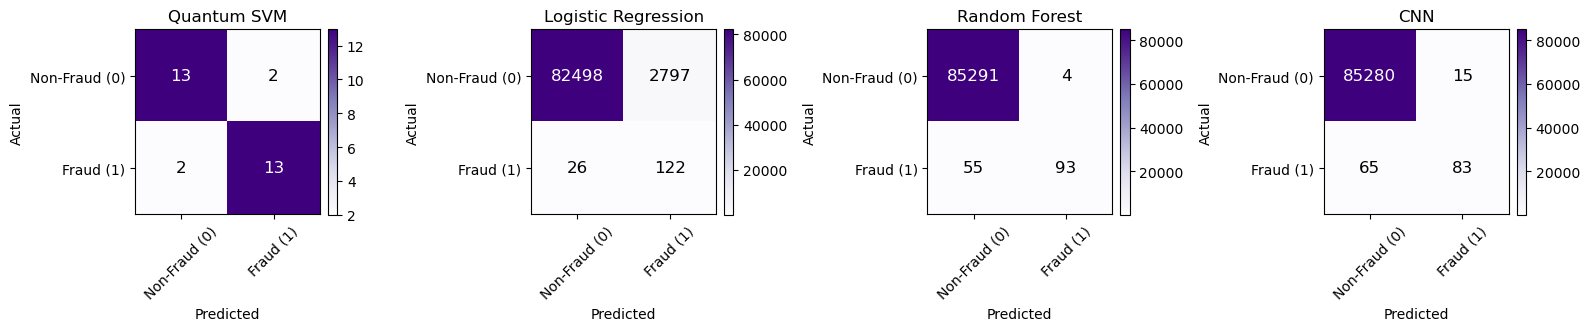

In [9]:
# ---------------------------
# Side-by-side Confusion Matrices
# ---------------------------
def plot_conf_matrices(models_preds, model_names, figsize=(16, 4)):
    """
    Plots multiple confusion matrices side by side.
    
    Args:
        models_preds: list of tuples (y_true, y_pred)
        model_names: list of model names (str)
        figsize: size of the figure
    """
    n_models = len(models_preds)
    plt.figure(figsize=figsize)

    for i, ((y_true, y_pred), name) in enumerate(zip(models_preds, model_names)):
        cm = confusion_matrix(y_true, y_pred)
        plt.subplot(1, n_models, i + 1)
        plt.imshow(cm, interpolation='nearest', cmap='Purples')
        plt.title(name, fontsize=12)
        plt.colorbar(fraction=0.046, pad=0.04)
        tick_marks = np.arange(2)
        plt.xticks(tick_marks, ['Non-Fraud (0)', 'Fraud (1)'], rotation=45)
        plt.yticks(tick_marks, ['Non-Fraud (0)', 'Fraud (1)'])

        # Add numbers inside cells
        thresh = cm.max() / 2
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                plt.text(
                    c, r, str(cm[r, c]),
                    ha="center", va="center",
                    color="white" if cm[r, c] > thresh else "black",
                    fontsize=12
                )
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()


# ---------------------------
# Call function with all models
# ---------------------------
plot_conf_matrices(
    models_preds=[
        (yq_test, qsvm.predict(K_test)),
        (y_test, log_model.predict(X_test)),
        (y_test, rf_model.predict(X_test)),
        (cnn_labels, cnn_pred)
    ],
    model_names=["Quantum SVM", "Logistic Regression", "Random Forest", "CNN"]
)


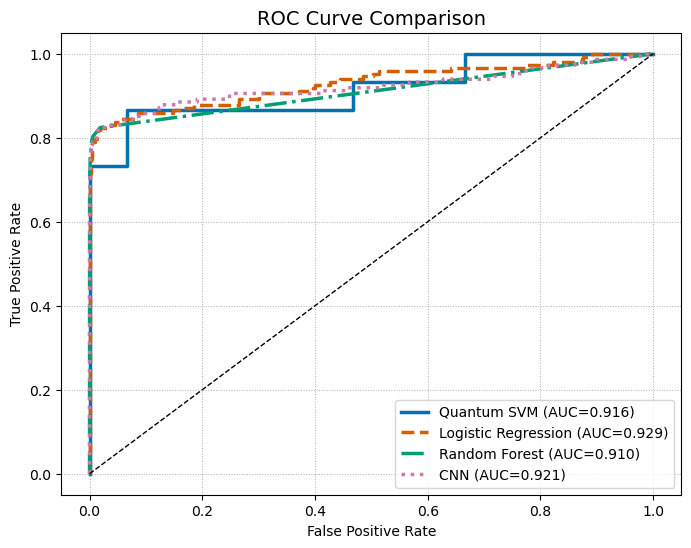

In [10]:
# ---------------------------
# Multi-Model ROC Curve
# ---------------------------
def plot_roc_multi(models, labels, title="ROC Curve Comparison"):
    """
    Plots ROC curves for multiple models in a single figure.
    
    Args:
        models: list of tuples [(y_true, y_score), ...]
        labels: list of model names corresponding to the models
        title: figure title
    """
    plt.figure(figsize=(8, 6))

    # Define colors and line styles for up to 4 models
    colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7"]
    linestyles = ["-", "--", "-.", ":"]

    # Plot ROC for each model
    for i, (y_true, y_score) in enumerate(models):
        fpr, tpr, _ = roc_curve(y_true, y_score)  # False/True Positive Rates
        roc_auc = auc(fpr, tpr)                   # Area under ROC

        plt.plot(
            fpr, tpr,
            lw=2.5,
            color=colors[i],
            linestyle=linestyles[i],
            label=f"{labels[i]} (AUC={roc_auc:.3f})"
        )

    # Diagonal line for random classifier
    plt.plot([0,1], [0,1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle=':', linewidth=0.7)
    plt.legend()
    plt.show()


# ---------------------------
# Call function for all models
# ---------------------------
plot_roc_multi(
    models=[
        (yq_test, qsvm.decision_function(K_test)),  # Quantum SVM
        (y_test, log_model.predict_proba(X_test)[:,1]),  # Logistic Regression
        (y_test, rf_model.predict_proba(X_test)[:,1]),   # Random Forest
        (y_test, cnn_scores)                             # PyTorch CNN
    ],
    labels=["Quantum SVM", "Logistic Regression", "Random Forest", "CNN"]
)


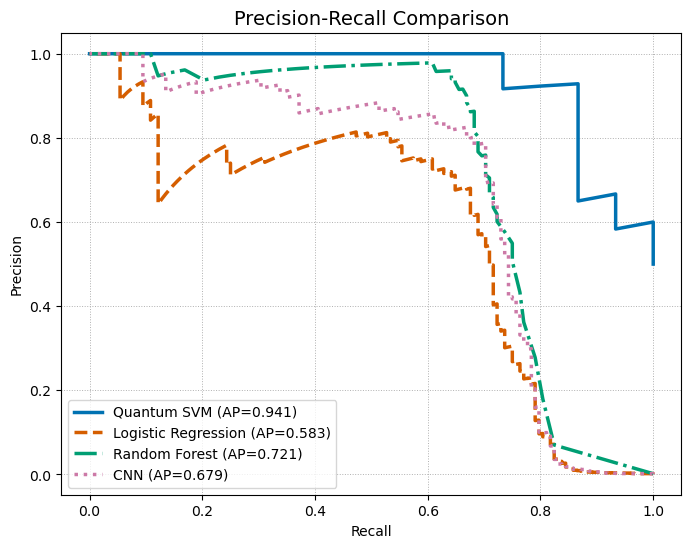

In [11]:
# ---------------------------
# Multi-Model Precision-Recall Curve
# ---------------------------
def plot_pr_multi(models, labels, title="Precision-Recall Comparison"):
    """
    Plots Precision-Recall curves for multiple models in a single figure.

    Args:
        models: list of tuples [(y_true, y_score), ...]
        labels: list of model names corresponding to the models
        title: figure title
    """
    plt.figure(figsize=(8, 6))

    # Define colors and line styles for clarity
    colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7"]
    linestyles = ["-", "--", "-.", ":"]

    # Plot PR curve for each model
    for i, (y_true, y_score) in enumerate(models):
        precision, recall, _ = precision_recall_curve(y_true, y_score)  # compute PR
        ap = average_precision_score(y_true, y_score)                   # area under PR

        plt.plot(
            recall, precision,
            lw=2.5,
            color=colors[i],
            linestyle=linestyles[i],
            label=f"{labels[i]} (AP={ap:.3f})"
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title, fontsize=14)
    plt.grid(True, linestyle=':', linewidth=0.7)
    plt.legend()
    plt.show()


# ---------------------------
# Call function for all models
# ---------------------------
plot_pr_multi(
    models=[
        (yq_test, qsvm.decision_function(K_test)),  # Quantum SVM
        (y_test, log_model.predict_proba(X_test)[:,1]),  # Logistic Regression
        (y_test, rf_model.predict_proba(X_test)[:,1]),   # Random Forest
        (y_test, cnn_scores)                             # PyTorch CNN
    ],
    labels=["Quantum SVM", "Logistic Regression", "Random Forest", "CNN"]
)
